## Objetivos generales

- Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
- Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
- Analizar los factores que más impactan la pérdida.
- Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
- identificar a los grupos objetivo;
- sugerir medidas para reducir la rotación;
- describir cualquier otro patrón que observes con respecto a la interacción con los clientes.


In [2]:
# Cargar librerías

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA






## Paso 1. Descargar los datos
El dataset incluye los siguientes campos:

- 'Churn' — la cancelación para el mes en cuestión

- Campos de dataset actuales:
    - Datos del usuario del mes anterior
        - 'gender'.
        - 'Near_Location' — si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.
        - 'Partner' — si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).
        - Promo_friends — si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).
        - 'Phone' — si el/la usuario/a aportó el número de teléfono.
        - 'Age'.
        - 'Lifetime' — el tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.
- Datos del registro de visitas y compras y datos sobre el estado actual de la membresía:
    - 'Contract_period' — 1 mes, 3 meses, 6 meses o 1 año.
    - 'Month_to_end_contract' — los meses que faltan hasta que expire el contrato.
    - 'Group_visits' — si el/la usuario/a participa en sesiones grupales.
    - 'Avg_class_frequency_total' — frecuencia media de visitas por semana a lo largo de la vida del cliente.
    - 'Avg_class_frequency_current_month' — frecuencia media de visitas por semana durante el mes en curso.
    - 'Avg_additional_charges_total' — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

In [3]:
# Importar datos

data = pd.read_csv("data/gym_churn_us.csv")
data.head(3)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0


## Llevar a cabo el análisis exploratorio de datos (EDA)
1. Observa el dataset: ¿contiene alguna característica ausente? Estudia los valores promedio y la desviación estándar (utiliza el método describe()).
1. Observa los valores medios de las características en dos grupos: para las personas que se fueron (cancelación) y para las que se quedaron (utiliza el método groupby()).
1. Traza histogramas de barras y distribuciones de características para aquellas personas que se fueron (cancelación) y para las que se quedaron.
1. Crea una matriz de correlación y muéstrala.

In [4]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

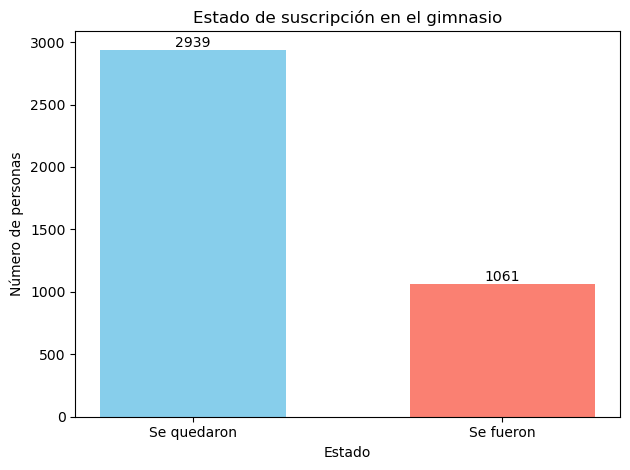

In [7]:
import matplotlib.pyplot as plt

# Conteos ordenados (0,1)
counts = data['churn'].astype(int).value_counts().sort_index()
labels = ["Se quedaron", "Se fueron"]
colors = ["skyblue", "salmon"]

fig, ax = plt.subplots()
bars = ax.bar([0, 1], counts.values, color=colors, width=0.6)

ax.set_xticks([0, 1])
ax.set_xticklabels(labels)
ax.set_xlabel("Estado")
ax.set_ylabel("Número de personas")
ax.set_title("Estado de suscripción en el gimnasio")

# Anotar valores
for b in bars:
    h = b.get_height()
    ax.annotate(int(h), (b.get_x() + b.get_width() / 2, h),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [8]:
# Observamos valores medios para las características de ambos grupos 

data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


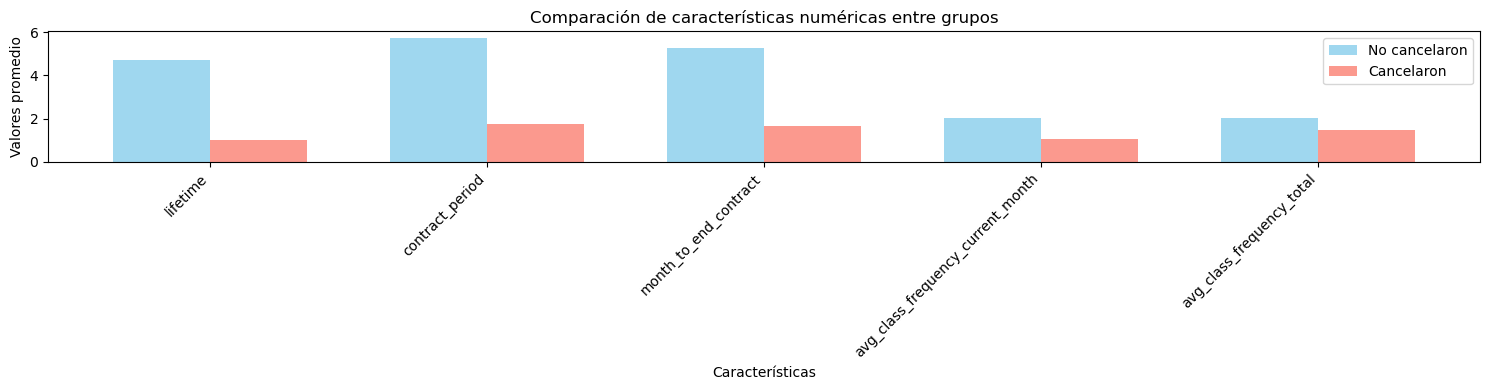

In [9]:
# Primero, calcula las medias por grupo
grupos_medias = data.groupby('churn').mean()

# Características numéricas
caracteristicas_numericas = ['lifetime', 'contract_period', 
                           'month_to_end_contract', 'avg_class_frequency_current_month', 'avg_class_frequency_total']

# Preparar los datos
no_cancelaron = grupos_medias.loc[0, caracteristicas_numericas]
cancelaron = grupos_medias.loc[1, caracteristicas_numericas]

# Crear el gráfico
x = np.arange(len(caracteristicas_numericas))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 4))
barras1 = ax.bar(x - width/2, no_cancelaron, width, label='No cancelaron', alpha=0.8,  color='skyblue')
barras2 = ax.bar(x + width/2, cancelaron, width, label='Cancelaron', alpha=0.8,  color='salmon')

ax.set_xlabel('Características')
ax.set_ylabel('Valores promedio')
ax.set_title('Comparación de características numéricas entre grupos')
ax.set_xticks(x)
ax.set_xticklabels(caracteristicas_numericas, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

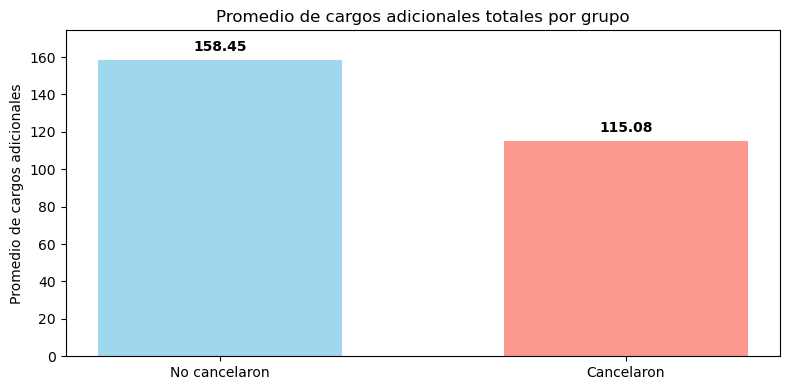

In [10]:
# Calcular las medias de avg_additional_charges_total por grupo
grupos_medias = data.groupby('churn')['avg_additional_charges_total'].mean()

# Preparar los datos
no_cancelaron = grupos_medias[0]
cancelaron = grupos_medias[1]

# Crear el gráfico
grupos = ['No cancelaron', 'Cancelaron']
valores = [no_cancelaron, cancelaron]

fig, ax = plt.subplots(figsize=(8, 4))
barras = ax.bar(grupos, valores, color=['skyblue', 'salmon'], alpha=0.8, width=0.6)

# Personalizar el gráfico
ax.set_ylabel('Promedio de cargos adicionales')
ax.set_title('Promedio de cargos adicionales totales por grupo')
ax.set_ylim(0, max(valores) * 1.1)  # Ajustar el límite superior

# Agregar los valores encima de las barras
for i, v in enumerate(valores):
    ax.text(i, v + max(valores) * 0.02, f'{v:.2f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

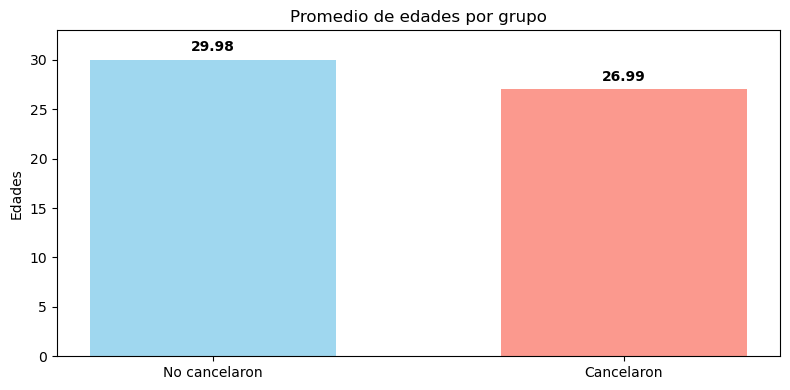

In [11]:
# Calcular las medias de avg_additional_charges_total por grupo
grupos_medias = data.groupby('churn')['age'].mean()

# Preparar los datos
no_cancelaron = grupos_medias[0]
cancelaron = grupos_medias[1]

# Crear el gráfico
grupos = ['No cancelaron', 'Cancelaron']
valores = [no_cancelaron, cancelaron]

fig, ax = plt.subplots(figsize=(8, 4))
barras = ax.bar(grupos, valores, color=['skyblue', 'salmon'], alpha=0.8, width=0.6)

# Personalizar el gráfico
ax.set_ylabel('Edades')
ax.set_title('Promedio de edades por grupo')
ax.set_ylim(0, max(valores) * 1.1)  # Ajustar el límite superior

# Agregar los valores encima de las barras
for i, v in enumerate(valores):
    ax.text(i, v + max(valores) * 0.02, f'{v:.2f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

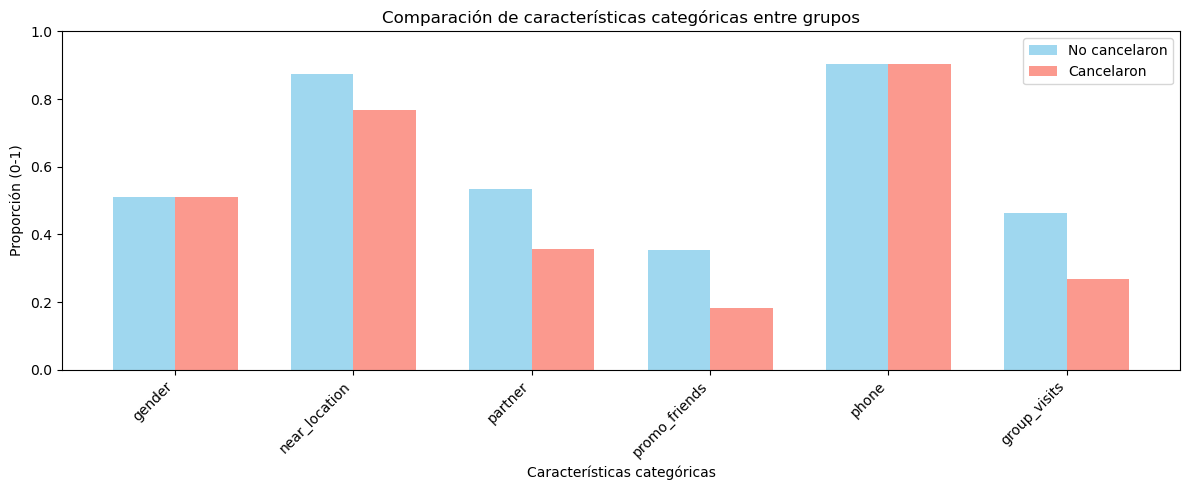

In [12]:
# Características categóricas (binarias)
caracteristicas_categoricas = ['gender', 'near_location', 'partner', 
                              'promo_friends', 'phone', 'group_visits']

# Calcular proporciones para cada característica
proporciones_no_cancelaron = []
proporciones_cancelaron = []

for caracteristica in caracteristicas_categoricas:
    # Filtrar por grupo
    no_cancelaron = data[data['churn'] == 0][caracteristica].mean()
    cancelaron = data[data['churn'] == 1][caracteristica].mean()
    
    proporciones_no_cancelaron.append(no_cancelaron)
    proporciones_cancelaron.append(cancelaron)

# Crear el gráfico
x = np.arange(len(caracteristicas_categoricas))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))
barras1 = ax.bar(x - width/2, proporciones_no_cancelaron, width, 
                 label='No cancelaron', alpha=0.8, color='skyblue')
barras2 = ax.bar(x + width/2, proporciones_cancelaron, width, 
                 label='Cancelaron', alpha=0.8, color='salmon')

ax.set_xlabel('Características categóricas')
ax.set_ylabel('Proporción (0-1)')
ax.set_title('Comparación de características categóricas entre grupos')
ax.set_xticks(x)
ax.set_xticklabels(caracteristicas_categoricas, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)  # Las proporciones van de 0 a 1

plt.tight_layout()
plt.show()

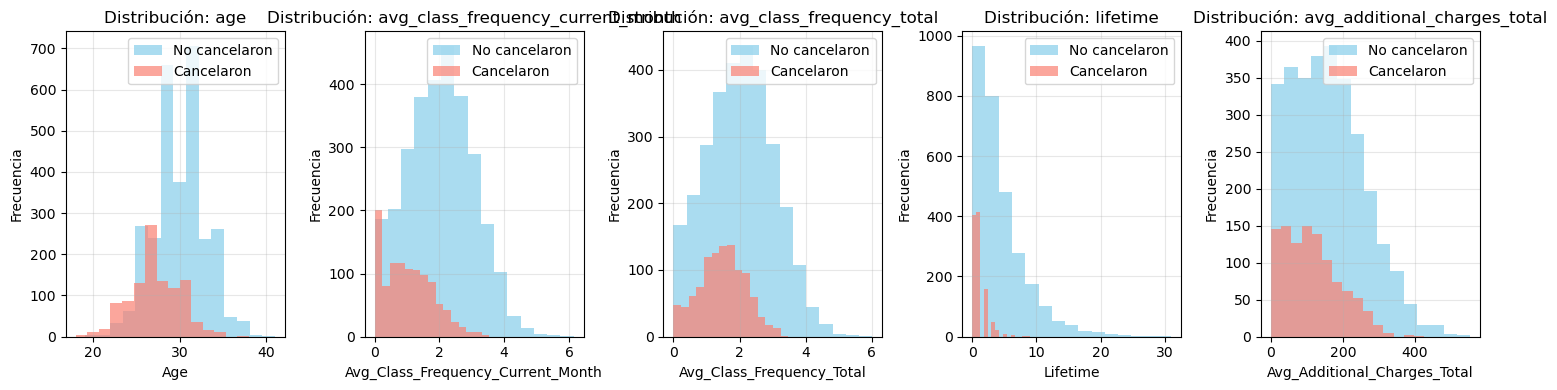

In [13]:
# Distribución de características numéricas
caracteristicas = ['age', 'avg_class_frequency_current_month','avg_class_frequency_total','lifetime','avg_additional_charges_total']

fig, axes = plt.subplots(1,5, figsize=(15,4))
axes = axes.ravel()

for i, caracteristica in enumerate(caracteristicas):
    no_cancelaron = data[data['churn'] == 0][caracteristica]
    cancelaron = data[data['churn'] == 1][caracteristica]
    bins = 15
    
    axes[i].hist(no_cancelaron, bins=bins, alpha=0.7, label='No cancelaron', color='skyblue')
    axes[i].hist(cancelaron, bins=bins, alpha=0.7, label='Cancelaron', color='salmon')
    
    axes[i].set_xlabel(caracteristica.title())
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución: {caracteristica}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

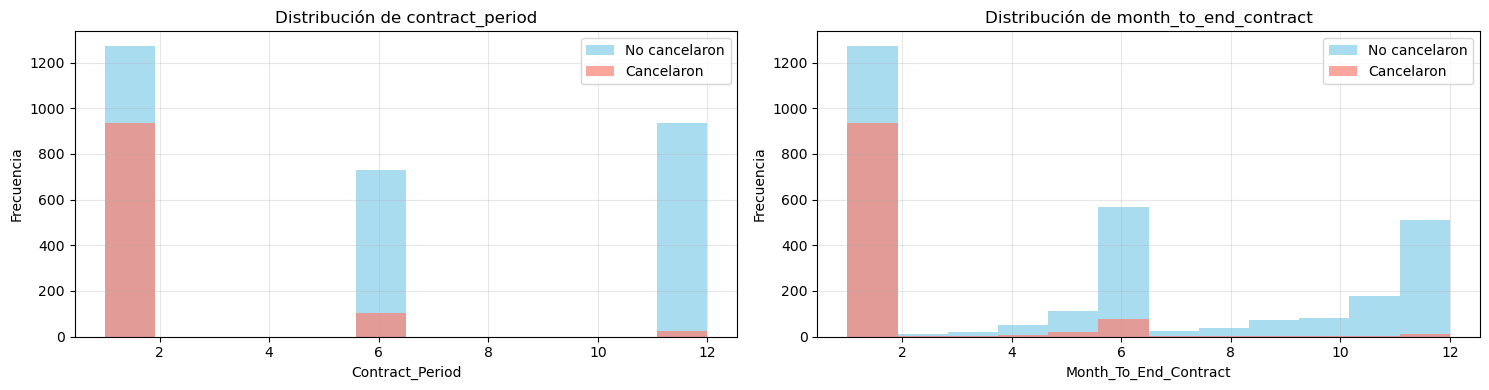

In [14]:
# Distribución de características numéricas mensuales 
caracteristicas = ['contract_period', 'month_to_end_contract']

fig, axes = plt.subplots(1,2, figsize=(15, 4))
axes = axes.ravel()

for i, caracteristica in enumerate(caracteristicas):
    no_cancelaron = data[data['churn'] == 0][caracteristica]
    cancelaron = data[data['churn'] == 1][caracteristica]
    bins = 12
    
    axes[i].hist(no_cancelaron, bins=bins, alpha=0.7, label='No cancelaron', color='skyblue')
    axes[i].hist(cancelaron, bins=bins, alpha=0.7, label='Cancelaron', color='salmon')
    
    axes[i].set_xlabel(caracteristica.title())
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {caracteristica}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

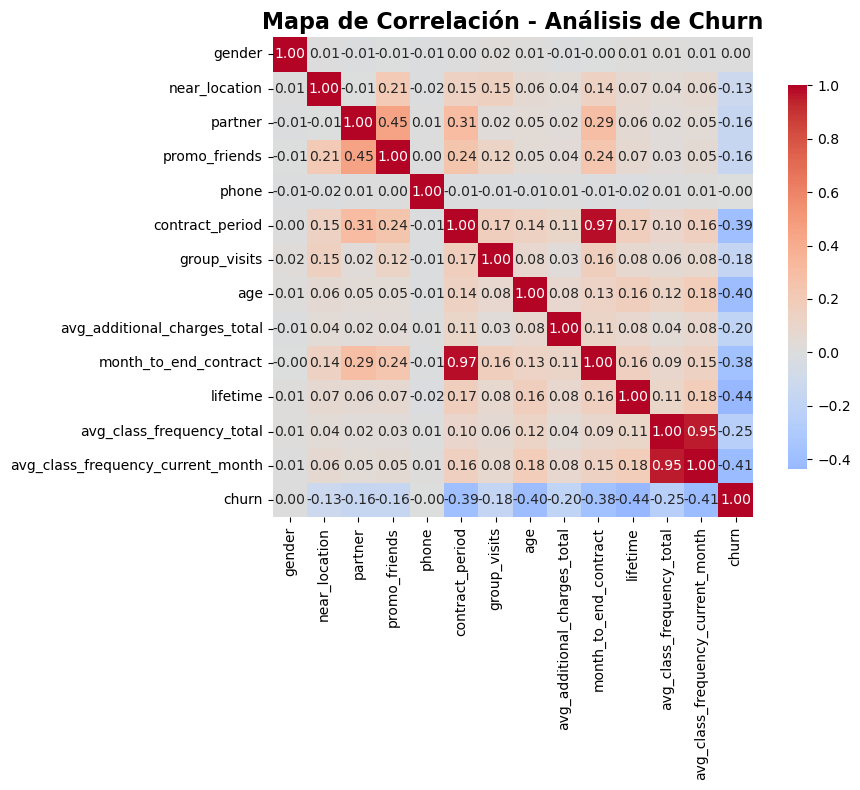

In [15]:
# Crear gráfica de correlación
# Crear la matriz de correlación
correlation_matrix = data.corr()

# Crear la figura
plt.figure(figsize=(10,8))

# Crear el mapa de calor
sns.heatmap(correlation_matrix, 
            annot=True,           # Mostrar los valores numéricos
            cmap='coolwarm',      # Esquema de colores
            center=0,             # Centrar en 0
            square=True,          # Hacer cuadrados
            fmt='.2f',            # Formato de números (2 decimales)
            cbar_kws={'shrink': 0.8})  # Ajustar barra de colores

plt.title('Mapa de Correlación - Análisis de Churn', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


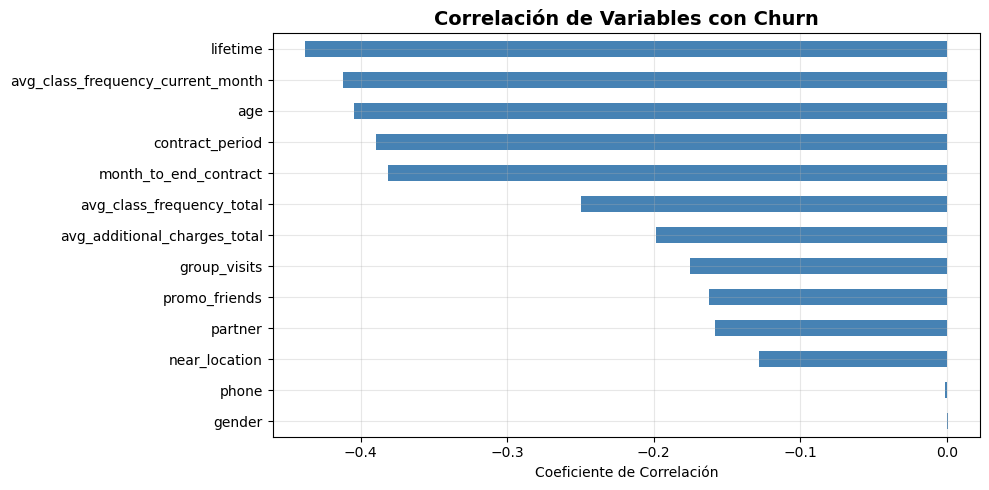

In [16]:
churn_correlations = data.corr()['churn'].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
churn_correlations.drop('churn').plot(kind='barh', color='steelblue')
plt.title('Correlación de Variables con Churn', fontsize=14, fontweight='bold')
plt.xlabel('Coeficiente de Correlación')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

El análisis exploratorio revela patrones claros entre clientes que cancelan vs. los que se quedan. Los clientes que hacen churn tienden a 
- Ser más jóvenes (27 años vs 30 años en promedio)
- Tener contratos por periodo más cortos
- Estar próximos a que su contrato se vensa
- Tienen menos frecuencia de clases, pero muy poco, la diferencia entre promedios es de 1 día
- Hacen menos gastos adicionales
 
Los clientes que se quedan, tienden a: 
- Inscribirse por medio de un código promocional
- Trabajar en una compañía asosiada
- Participar en sesiones grupales

Las características que no afectan en la cancelación o no cancelación son:
- Teléfono
- Género

## Paso 3. Construir un modelo para predecir la cancelación de usuarios
Crea un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario o la usuaria el mes siguiente.

1. Divide los datos en conjuntos de entrenamiento y validación utilizando la función train_test_split().
1. Entrena el modelo en el set de entrenamiento con dos métodos:
regresión logística;
bosque aleatorio.
1. Evalúa la exactitud, precisión y recall para ambos modelos utilizando los datos de validación. Utilízalos para comparar los modelos. ¿Qué modelo dio mejores resultados?
1. Recuerda indicar el parámetro random_state cuando dividas los datos y definas el algoritmo. 

In [17]:
# Eliminar filas con valores ausentes
data.dropna(inplace=True)

# Separar columnas categóricas (ajusta según tu dataset)
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
if 'churn' in categorical_cols:
    categorical_cols.remove('churn')  # no codificar la variable objetivo

# Codificar variables categóricas
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Features y target
X = data.drop(columns='churn')
y = data['churn'].astype(int)  # aseguramos que sea entero

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# Escalado (opcional, útil si usarás modelos que dependan de la escala, como LogisticRegression)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# -----------------------------
# Definir modelos
# -----------------------------
models = [
    DecisionTreeClassifier(random_state=1),
    RandomForestClassifier(n_estimators=100, random_state=1)
]

# -----------------------------
# Función de evaluación para clasificación
# -----------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # para ROC-AUC

    print(model.__class__.__name__)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.2f}")
    print("-" * 30)

# -----------------------------
# Entrenar y evaluar todos los modelos
# -----------------------------
for model in models:
    evaluate_model(model, X_train_st, y_train, X_test_st, y_test)

DecisionTreeClassifier
Accuracy: 0.89
Precision: 0.81
Recall: 0.77
F1 Score: 0.79
ROC-AUC: 0.85
------------------------------
RandomForestClassifier
Accuracy: 0.93
Precision: 0.91
Recall: 0.81
F1 Score: 0.86
ROC-AUC: 0.97
------------------------------


De los dos modelos probados, Random Forest obtiene el mejor desempeño global en predicción de churn, con un ROC-AUC de 0.97 que indica una excelente capacidad para discriminar entre clientes que se quedan y los que se van.

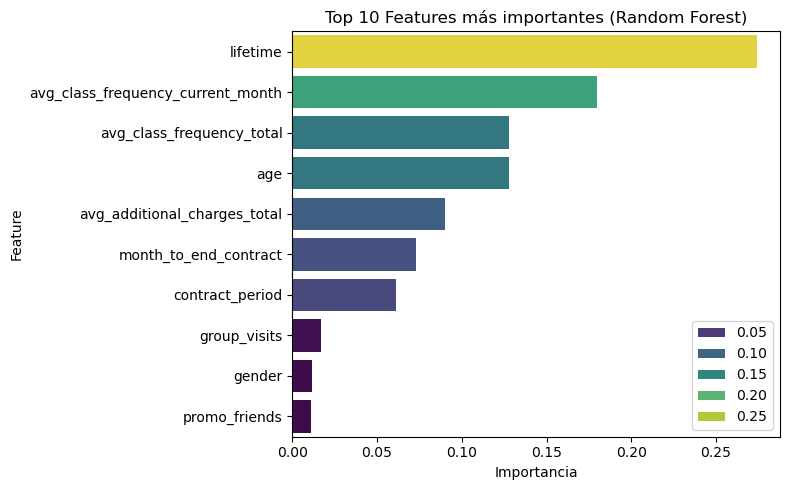

In [18]:
# Importancia de features del Random Forest

# Usamos el Random Forest ya entrenado
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train_st, y_train)

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)[:10]  # Top 10

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importances.values, y=feature_importances.index, hue = feature_importances.values, palette='viridis')
plt.title('Top 10 Features más importantes (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Paso 4. Crear clústeres de usuarios/as
Deja de lado la columna con datos sobre la cancelación e identifica los clústeres de objetos (usuarios/as):

1. Estandariza los datos.
1. Utiliza la función linkage() para crear una matriz de distancias basada en la matriz de características estandarizada y trazar un dendrograma. Nota: ¡renderizar el dendrograma puede llevar tiempo! Utiliza el gráfico resultante para estimar el número de clústeres que puedes destacar.
1. Entrena el modelo de clustering con el algortimo K-means y predice los clústeres de clientes. (Deja que el número de clústeres sea n=5 para que sea más sencillo comparar los resultados con los del resto del estudiantado. Sin embargo, en la vida real, nadie te dará tales pistas, así que tendrás que decidir basándote en el gráfico del paso anterior.)
1. Mira los valores medios de característica para los clústeres.¿Hay algo que te llame la atención?
1. Traza distribuciones de características para los clústeres. ¿Notas algo?
1. Calcula la tasa de cancelación para cada clúster (utiliza el método groupby()). ¿Difieren en términos de tasa de cancelación? ¿Qué grupos son propensos a irse y cuáles son leales?

In [19]:
# 1) Trabajamos sobre una copia por seguridad
df = data.copy()

# 2) Eliminar filas con NA — si prefieres imputar, dime y lo cambiamos
df = df.dropna()

# 3) Separamos X (features) y dejamos 'churn' fuera para clustering
X = df.drop(columns='churn')
y = df['churn'].astype(int)  # lo guardamos aparte por si luego queremos analizar churn por cluster

# 4) Convertir booleanos a 0/1 (si hay columnas booleanas)
bool_cols = X.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    X[bool_cols] = X[bool_cols].astype(int)

# 5) Detectar columnas categóricas que necesitan dummies (object/category)
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 6) One-hot encoding de las categóricas (drop_first=True para reducir dimensión)
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 7) Estandarizar (media 0, varianza 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)  # devuelve numpy array

# 8) (Opcional) volver a DataFrame con nombres de columnas (útil para inspección y plotting)
X_scaled_df = pd.DataFrame(X_scaled, index=X_encoded.index, columns=X_encoded.columns)

# --- Información rápida de salida ---
print("Original shape:", X.shape)
print("After encoding shape:", X_encoded.shape)
print("After scaling shape:", X_scaled_df.shape)
display(X_scaled_df.head())   # en Jupyter esto muestra una tabla bonita


Original shape: (4000, 13)
After encoding shape: (4000, 13)
After scaling shape: (4000, 13)


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0.979706,0.427881,1.026861,1.497161,-3.059852,0.289890,1.194032,-0.056554,-1.377531,0.161605,-0.193329,-1.911920,-1.678472
1,-1.020715,0.427881,-0.973842,-0.667931,0.326813,1.608822,1.194032,0.557327,-0.350213,1.831941,0.873680,0.045176,0.136014
2,-1.020715,0.427881,1.026861,-0.667931,0.326813,-0.809219,-0.837498,-0.363494,-0.181592,-0.792873,-0.460081,-0.020493,-0.029019
3,-1.020715,0.427881,1.026861,1.497161,0.326813,1.608822,1.194032,1.171208,-0.874722,1.831941,-0.460081,1.364655,1.510450
4,0.979706,0.427881,1.026861,1.497161,0.326813,-0.809219,-0.837498,-0.977375,0.533700,-0.792873,-0.193329,-0.787076,-0.614542


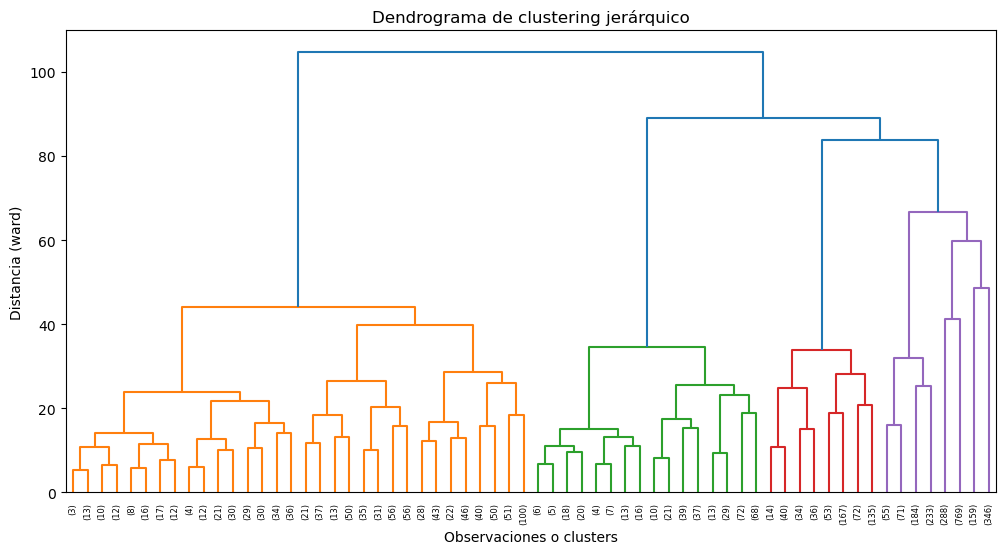

In [20]:
# --- 1. Crear matriz de enlace ---
# "ward" minimiza la varianza intra-cluster (muy usado con datos escalados)
Z = linkage(X_scaled, method='ward')

# --- 2. Graficar dendrograma ---
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)  # p controla cuántos niveles mostrar
plt.title("Dendrograma de clustering jerárquico")
plt.xlabel("Observaciones o clusters")
plt.ylabel("Distancia (ward)")
plt.show()

In [21]:
# --- 1. Entrenar K-Means con 5 clústeres ---
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10)  
# (n_init=10 es buena práctica para evitar soluciones locales malas)

kmeans.fit(X_scaled)

# --- 2. Predicciones de clúster ---
clusters = kmeans.labels_

# --- 3. Añadir la columna de clúster a tu DataFrame original ---
data['cluster'] = clusters

# --- 4. Info rápida ---
print("Tamaño de cada clúster:")
print(data['cluster'].value_counts().sort_index())

# --- 5. (Opcional) Centroides estandarizados ---
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_scaled_df.columns)
print("\nCentroides (escalados):")
display(centroids)

Tamaño de cada clúster:
cluster
0     872
1     625
2     386
3    1249
4     868
Name: count, dtype: int64

Centroides (escalados):


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0.116824,0.007123,-0.419872,-0.521775,0.326813,-0.439496,0.066695,0.257762,0.136442,-0.439039,0.289206,0.933239,0.961014
1,-0.030122,0.286087,0.664554,1.493691,0.326813,-0.362882,0.054552,-0.032451,-0.058481,-0.354639,0.001178,-0.162978,-0.146122
2,0.026138,0.048233,-0.030506,-0.006063,-3.059852,0.021092,0.030902,0.034892,-0.028394,0.034259,0.057529,-0.025521,-0.040925
3,-0.060577,-0.338692,-0.382288,-0.638438,0.326813,-0.609830,-0.275897,-0.327094,-0.177378,-0.598421,-0.405790,-0.651832,-0.737058
4,-0.020504,0.252680,0.508245,0.372211,0.326813,1.570834,0.276567,0.218561,0.172314,1.542189,0.265805,0.126019,0.215322


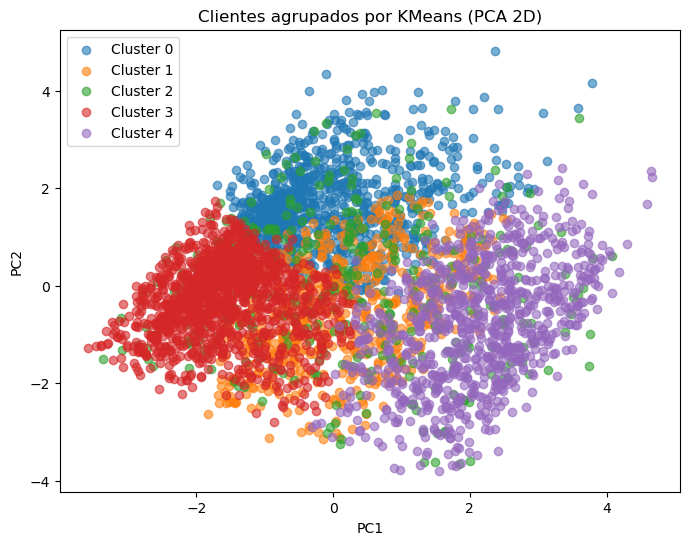

In [22]:
# Reducimos a 2 componentes principales
pca = PCA(n_components=2, random_state=1)
X_pca = pca.fit_transform(X_scaled)

# Creamos un DataFrame con los 2 componentes y los clusters
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = data['cluster']

# Graficamos
plt.figure(figsize=(8,6))
for c in sorted(pca_df['cluster'].unique()):
    subset = pca_df[pca_df['cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {c}', alpha=0.6)

plt.title("Clientes agrupados por KMeans (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


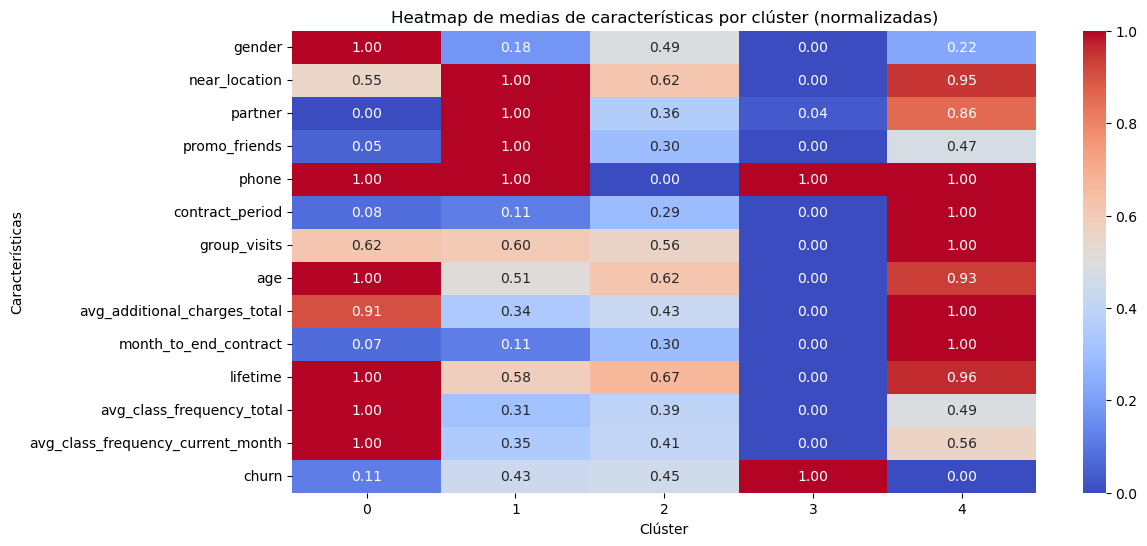

In [38]:
# --- 1. Calcular medias por cluster ---
cluster_means = data.groupby('cluster').mean(numeric_only=True)

# --- 2. Escalar las medias para compararlas mejor ---
cluster_means_scaled = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# --- 3. Graficar heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(cluster_means_scaled.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Heatmap de medias de características por clúster (normalizadas)")
plt.xlabel("Clúster")
plt.ylabel("Características")
plt.show()


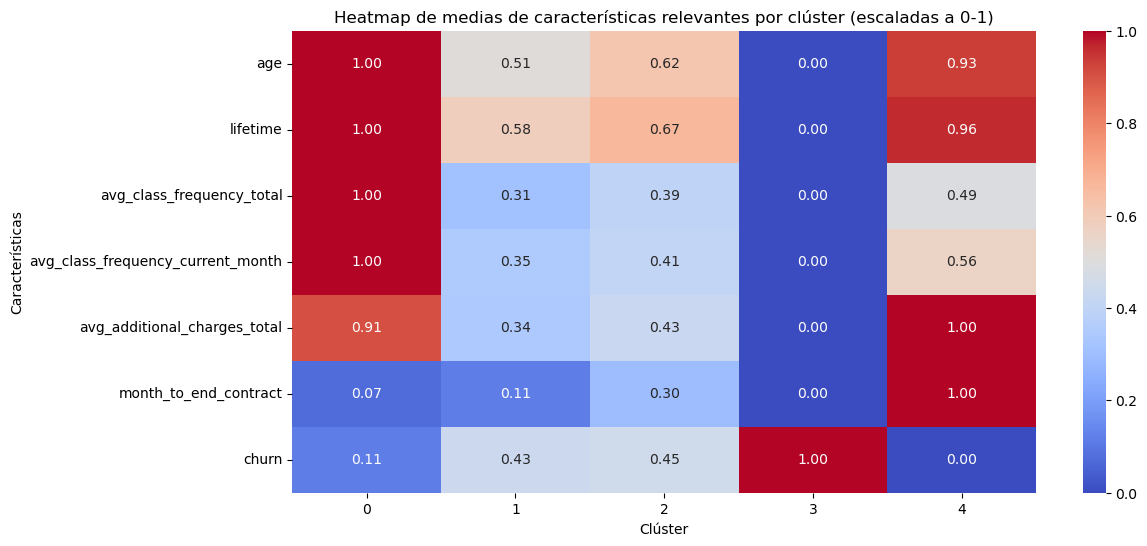

In [39]:
# --- 1. Calcular medias por cluster (solo en features relevantes) ---
relevant_features = [
    'age', 'lifetime', 
    'avg_class_frequency_total', 'avg_class_frequency_current_month',
    'avg_additional_charges_total', 'month_to_end_contract', 'churn'
]

cluster_means = data.groupby('cluster')[relevant_features].mean()

# --- 2. Escalar las medias a [0,1] para compararlas mejor ---
cluster_means_scaled = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# --- 3. Graficar heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(cluster_means_scaled.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Heatmap de medias de características relevantes por clúster (escaladas a 0-1)")
plt.xlabel("Clúster")
plt.ylabel("Características")
plt.show()


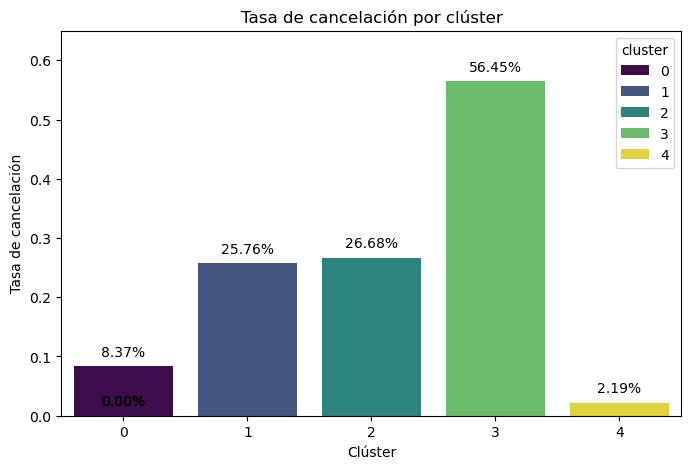

In [54]:
# --- 1. Calcular tasa de cancelación por clúster ---
churn_rate = data.groupby('cluster')['churn'].mean()

# --- 2. Gráfico de barras con etiquetas ---
plt.figure(figsize=(8,5))
ax = sns.barplot(x=churn_rate.index, y=churn_rate.values, hue = churn_rate.index, palette="viridis")

plt.title("Tasa de cancelación por clúster")
plt.xlabel("Clúster")
plt.ylabel("Tasa de cancelación")
plt.ylim(0,0.65)

# --- 3. Añadir etiquetas encima de cada barra ---
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2%}",   # formato porcentaje
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0,5),
                textcoords='offset points')

plt.show()

## Paso 5. Saca conclusiones y haz recomendaciones básicas sobre el trabajo con clientes
Llega a conclusiones y formula recomendaciones con respecto a la estrategia para la interacción y retención de clientes.

No necesitas entrar en detalles. Bastarán tres o cuatro principios esenciales y ejemplos de su implementación en forma de pasos de marketing específicos.

### Conclusiones

**Clúster 0: Antiguos y fieles**

Edad, lifetime, frecuencia = todos en el máximo (1.0).
Casi máximos también en cargos adicionales (0.90).
Muy bajo churn (0.11).


**Clúster 1: Zona gris, alto riesgo de churn**

Valores medios-bajos en todo.
Churn relativamente alto (0.43).


**Clúster 2: "Zona gris, alto riesgo de churn**

Un poco más altos que el clúster 1 en todas las métricas.
Churn relativamente alto (0.45).


**Clúster 3: Los que ya se fueron**

Todo en 0 excepto churn = 1.


**Clúster 4: Clientes top**

Edad y lifetime muy altos (0.93, 0.96).
Buena frecuencia de uso actual (0.56).
Máximo en cargos adicionales (1.0) y contratos (1.0).
Churn = 0.0.

### Recomendaciones

**Cluster 0 y 4: Antiguos y fieles**
Campañas de fidelización. Premiarlos por ser buenos clientes, darles promociones de referidos, usarlos como embajadores. Ofrecerles membrecías premium aprovechando que ya están gastando en servicios extra.

**Cluster 1 y 2: Alto riesgo de abandonar**
Promociones personalizadas, descuentos en renovación, recompensas por asistir más de x veces al mes. Detectar señales de desmotivación.

**Cluster 3: Los que se van a ir**
Atención temprana, seguimiento en las primeras semanas, clases de bienvenida, ofrecer incentivos como retos de 1 mes antes de que se vayan.